## Dataset cleaning and preprocessing - Experimental setting
Make proper sentence seperator add space after each full stop if there is no space
1. Make generalizable code to work on given dataset
2. Make generalizable code to work on given feature set
3. Make generalizable code to work on given classifier
4. save properly preprocessed dataset


## Noise Removel

1. URL and HTML code  special character removal
2. user mention, email removal,retweet tags
3. non sinhala word removal

## Preprocessing

1. puntuation removal
2. pntuation removel keeping (! and ?)
3. Emoji removal, replacement
4. Stop words removal
5. stemming - https://github.com/rksk/sinhala-news-analysis - citaion using singling tool
6. text normalization
7. Hashtag treatment - advance and ambiguous

check words start with hashtag posibility of dividing it to words

In [ ]:
load_dotenv()
NEPTUNE_PROJECT= os.getenv('NEPTUNE_PROJECT')
NEPTUNE_API_TOKEN = os.getenv(('NEPTUNE_API_TOKEN'))
neptune.init(project_qualified_name= NEPTUNE_PROJECT,api_token=NEPTUNE_API_TOKEN) 

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score, f1_score, precision_score,roc_curve,roc_auc_score,confusion_matrix,recall_score
from sklearn.pipeline import Pipeline
import re
import gensim
pd.set_option('display.max_colwidth', 1000)
# import helper function script
import sys
sys.path.insert(1,'G:\\Github\\Sinhala-Hate-Speech-Detection')
import utills
import sinhala_stemmer

In [60]:
# load datasets
path = '../Datasets/processed/no_preprocessing/'
df_A = pd.read_csv(path+'df_A.csv')    
df_B = pd.read_csv(path+'df_B.csv') 
df_A_B = pd.read_csv(path+'df_A_B.csv')
df_all = pd.read_csv(path+'df_all.csv') 

In [70]:


def sentenceSeperator(txt):
    return re.sub(r'[\.?;!,\u2022]', r'\g<0> ',txt)

def removePunctuationSpecial(txt):
    exclude = set(
        ".…,‌ ¸‚\"/|—¦”‘\'“’´`<>#@$%^=&*+\-£˜()\[\]{\}:;–_‪‬‏")

    return ''.join([(c if c not in exclude else " ") for c in txt])

def removePunctuation(txt):
    """
    replace URL of a text
    :param text: text to replace urls
    :return: url removed text
    """
    # set(",.:;'\"-/´`%")
    exclude = set(
        ".…,‌ ¸‚\"/|—¦”‘\'“’´!?<>@#$%^=&*+\-£˜()\[\]{\}:;–_")

    return ''.join([(c if c not in exclude else " ") for c in txt])

def removeSpecialCharacters(txt):
    exclude = set(
        "Ê�\u00a0\u2003\ufffd\uf020\uf073\uf06c\uf190\u202a\u202c\u200f\u200c\u0160\u00ad\u0088\uf086\u200b\ufeff")

    return ''.join([(c if c not in exclude else '') for c in txt])
# removing digits


def removeNumber(txt):
    """
    replace number of a text
    :param text: text to replace number
    :return: numbers removed text
    """
    return ''.join(c for c in txt if not c.isnumeric())

# Remove emojis


def removeEmoji(txt):
    """
    replace emoji of a text with ''
    :param text: text to replace emojis
    :return: emoji removed text
    """
    import emoji
    return emoji.get_emoji_regexp().sub(u'', txt)

# def replaceEmoji(txt):
#     print()

def removeUrl(txt):
    """
    replace URL of a text
    :param text: text to replace urls
    :return: url removed text
    """
    import re
    return re.sub(r'(http://www\.|https://www\.|http://|https://)[a-z0-9]+([\-.]{1}[a-z0-9A-Z/]+)*', '', txt)


def removeRetweetState(txt):
    """
    remove retweet states in the beginning such as "RT @sam92ky: "
    :param text: text
    :return: text removed retweets state
    """

    return re.sub(r'RT @\w*: ', '', txt)


def removeMention(txt):
    """
    replace @username of a text
    :param text: text to replace username
    :return: username removed text
    """
    return re.sub(r'@[a-zA-Z]+', '', txt)
    #return re.sub(r'@\w*', '', txt)


def removeEnglishWords(txt):

    return re.sub(r'[a-zA-Z]+', '', txt)


def removeSentenceContainsEnglish(df, col):
    """
    remove rows contains english letter string of a dataframe
    :param df: Name of dataframe
    :param col : Column inclding text
    :return: Dataframe contains non englsih charachters
    """

    print("Input dataframe size = ", len(df))
    for s in df[col]:
        english_list = re.findall(r'[a-zA-Z]+', s)
        # print(english_list)
        if (english_list != []):
            i = df[df[col] == s].index
            df.drop(i, axis=0, inplace=True)
            # print(s)
    print("Cleaned dataframe size - removed Strings contain Englishs letters ", len(df))
    return df

# remove stop words


# def removeStopWords(txt, stop_words):
#     #lst_text = text.split()
#     #lst_text = [word for word in lst_text if word not in lst_stopwords]
#     return ''.join([(w if w not in stop_words else " ") for w in txt])


def identifySinhalaText(txt):

    sinhala_list = re.findall(r'[\u0D80-\u0DFF]+', txt)
    return sinhala_list
# def ignore_characters(txt):
#     return ' '.join(c for c in txt if not c.startswith('\u'))



def stemWords(txt):
    from sinling import SinhalaStemmer
    stemmer = SinhalaStemmer()
    
    #stemmed = stemmer.stem(word)[0]
    return ' '.join([ stemmer.stem(w)[0] for w in txt.split()])
    #   text =[]
    # for word in txt.split():
    #     #print(word)
    #     if len(word) < 4:
    #         word = word

    #     # remove 'ට'
    #     if word[-1] == 'ට':
    #         word =word[:-1]

    #     # remove 'ද'
    #     elif word[-1] == 'ද':
    #         word =word[:-1]

    #     # remove 'ටත්'
    #     elif word[-3:] == 'ටත්':
    #         word = word[:-3]

    #     # remove 'එක්'
    #     elif word[-3:] == 'ෙක්':
    #         word = word[:-3]

    #     # remove 'එ'
    #     elif word[-1:] == 'ෙ':
    #         word = word[:-1]

    #     # remove 'ක්'
    #     elif word[-2:] == 'ක්':
    #         word =word[:-2]

    #     # remove 'ගෙ' (instead of ගේ because this step comes after simplifying text)
    #     elif word[-4:] == 'ගේ':
    #         word = word[:-4]
    #     elif word[-3:] == 'ෙන්':
    #         word =word[:-3]
    #     text.append(word)
    #print(text)
    # return ' '.join(text)
        

def custom_stemmer(txt):
    ## custom stemmer longest prefix len >5
    stemmer = sinhala_stemmer.SinhalaStemmer()
    return ' '.join([stemmer.stem(w)[0] for w in txt.split()])
    #w_list=[]
    # for w in txt3.split():
    
    #     results = stemmer.stem(w)[0]
    # #results = preprocess(w)
#     w_list.append(results)
# print(' '.join(w_list))

#def text_normalize():


def removeStopWords(txt):
    """
    remove stop words
    """
    stop_words = List = open('G:\Github\Sinhala-Hate-Speech-Detection\Datasets\stop_words.txt', encoding='utf-8').read().splitlines()
    remove_stop_words = ['ඕහෝ','අනේ','අඳෝ','අපොයි','අපෝ','අයියෝ','ආයි','ඌයි','චී','චිහ්','චික්','නෑ', 'එම්බා','එම්බල','බොල']
    for w in remove_stop_words:
        if w in stop_words:
            stop_words.remove(w)
    return ' '.join([(w if w not in stop_words else ' ') for w in txt.split()])

def removeUnicode(txt):
    exclude = set(
        "\u200c\u200b\u2063")

    return ''.join([(c if c not in exclude else '') for c in txt])
# def POS_tags():

# def NER():

def preprocessor(df,col, seperator = False,url=False,mention=False,number=False,non_sinhala=False,special_characters=False,puntuation=False, puntuation_special = False, emoji_remove = False,  stop_word = False,stem=False,custom_stem=False):
    

   # if(tokenize):
    df['cleaned'] = df[col]
    if(seperator):
        df['cleaned'] = df['cleaned'].apply(lambda x: sentenceSeperator(x))
        print('seperator')
    if(url):
        df['cleaned'] = df['cleaned'].apply(lambda x: removeUrl(x))
        print('-url-')
    if(mention):
        df['cleaned'] = df['cleaned'].apply(lambda x: removeMention(x))
        print('-mention-')
    if(number):
        df['cleaned'] = df['cleaned'].apply(lambda x: removeNumber(x))
        print('-number-')
    if(non_sinhala):
        df['cleaned'] = df['cleaned'].apply(lambda x: removeEnglishWords(x))
        print('-non_sinhala-')
    if(special_characters):
        df['cleaned'] = df['cleaned'].apply(lambda x: removeSpecialCharacters(x))
        print('-special charactrer-')
    if(puntuation):
        df['cleaned'] = df['cleaned'].apply(lambda x: removePunctuation(x))
        print('-puntuation-')
    if(puntuation_special):
        df['cleaned'] = df['cleaned'].apply(lambda x: removePunctuationSpecial(x))
        print('-puntuation_special-')
    if(emoji_remove):
        df['cleaned'] = df['cleaned'].apply(lambda x: removeEmoji(x))
        print('-emoji remove-')
    #if(emoji_replace):

    if(stop_word):
        df['cleaned'] = df['cleaned'].apply(lambda x: removeStopWords(x))
        print('-stop word-')
    df['cleaned'] = df['cleaned'].apply(lambda x: removeUnicode(x))
    if(stem):
        df['cleaned'] = df['cleaned'].apply(lambda x: stemWords(x))
        print('-stem-')
    if(custom_stem):
        df['cleaned'] = df['cleaned'].apply(lambda x: custom_stemmer(x))
        print('-custome stemmer-')
    #if(text_normalize):

    return df

## Stemming experiments

In [19]:
def stemWords(txt):
    from sinling import SinhalaStemmer
    stemmer = SinhalaStemmer()
    
    #stemmed = stemmer.stem(word)[0]
    return ' '.join([ stemmer.stem(w)[0] for w in txt.split()])
v = 'ගුරුවරියට ප්‍රකාශ'
f=stemWords(txt3)
print(f)
f

අනුයුක්‌ත කර ඇ අතර එ පාසල දෙමළ මාධ්‍ය කර්ණ සංගීත විෂය ඉගෙ ගන් සිස නැත.  නිස විදුහල්පතිවර ගුරු ප්‍රකාශ කර ඇත්ත වෙන විෂයයක්‌ උගන්ව ලෙසය.ඇතැ කලාප යෑව ගුරු පුරප්පාඩ නොමැ ව නිස පත්ව ලබාද නැ අතර මෙ තත්ත්ව යටත එ උපාධිධාර දැඩි අපහසුතා පත්ව


'අනුයුක්\u200cත කර ඇ අතර එ පාසල දෙමළ මාධ්\u200dය කර්ණ සංගීත විෂය ඉගෙ ගන් සිස නැත.  නිස විදුහල්පතිවර ගුරු ප්\u200dරකාශ කර ඇත්ත වෙන විෂයයක්\u200c උගන්ව ලෙසය.ඇතැ කලාප යෑව ගුරු පුරප්පාඩ නොමැ ව නිස පත්ව ලබාද නැ අතර මෙ තත්ත්ව යටත එ උපාධිධාර දැඩි අපහසුතා පත්ව'

In [6]:
# using singling word spitter
from sinling import word_splitter

txt3 = 'අනුයුක්‌ත කර ඇති අතර එම පාසලේ දෙමළ මාධ්‍යයෙන් කර්ණාට සංගීත විෂයය ඉගෙන ගන්නා සිසුන් නැත. මේ නිසා විදුහල්පතිවරයා ගුරුවරියට ප්‍රකාශ කර ඇත්තේ වෙනත් විෂයයක්‌ උගන්වන ලෙසය.ඇතැම් කලාපවලට යෑවූ ගුරුවරුන්ට පුරප්පාඩු නොමැති වීම නිසා පත්වීම් ලබාදී නැති අතර මෙම තත්ත්වය යටතේ එම උපාධිධාරීහු දැඩි අපහසුතාවට පත්වූහ'


w_list=[]
for w in txt3.split():
    results = word_splitter.split(w)
    w_list.append(results['base'])

print(' '.join(w_list))

අනුයුක්‌ ක් ඇත අත එ පාසල් දෙ මාධ්‍ය කර්ණ සං විෂය ඉ ගන්න සිසු නැත ම නි විදුහල්පති ගුරුවරිය ප්‍ර ක් ඇත්ත වෙන ව උ ලෙසය.ඇතැම කලාප යෑ ගුරුවරුන් පුර නොමැත වී නි පත්වී ලබා නැත අත ම තත්ත්ව යටත් එ උපාධිධාරී දැ අපහසුතා පත්වූ


word_splitter is much worser than singling stemming and time to process this is too much expensive

In [16]:
## without changes len >5 - orginal singling implmentaion
txt3 = 'අනුයුක්‌ත කර ඇති අතර එම පාසලේ දෙමළ මාධ්‍යයෙන් කර්ණාට සංගීත විෂයය ඉගෙන ගන්නා සිසුන් නැත. මේ නිසා විදුහල්පතිවරයා ගුරුවරියට ප්‍රකාශ කර ඇත්තේ වෙනත් විෂයයක්‌ උගන්වන ලෙසය.ඇතැම් කලාපවලට යෑවූ ගුරුවරුන්ට පුරප්පාඩු නොමැති වීම නිසා පත්වීම් ලබාදී නැති අතර මෙම තත්ත්වය යටතේ එම උපාධිධාරීහු දැඩි අපහසුතාවට පත්වූහ'
stemWords(txt3)

'අනුයුක්\u200cත කර ඇ අතර එ පාසල දෙමළ මාධ්\u200dය කර්ණ සංගීත විෂය ඉගෙ ගන් සිස නැත.  නිස විදුහල්පතිවර ගුරු ප්\u200dරකාශ කර ඇත්ත වෙන විෂයයක්\u200c උගන්ව ලෙසය.ඇතැ කලාප යෑව ගුරු පුරප්පාඩ නොමැ ව නිස පත්ව ලබාද නැ අතර මෙ තත්ත්ව යටත එ උපාධිධාර දැඩි අපහසුතා පත්ව'

### custom stemmer

In [31]:
## shortest prefix with len >5
stemmer = sinhala_stemmer.SinhalaStemmer()
w_list=[]
for w in txt3.split():
    #results = word_splitter.split(w)
    results = stemmer.stem(w)[0]
    #results = preprocess(w)
    w_list.append(results)
print(' '.join(w_list))

අනුයුක්‌ත කර ඇති අතර එම පාසලේ දෙමළ මාධ්‍යයෙන කර්ණා සංගීත විෂයය ඉගෙන ගන්නා සිසුන නැත. මේ නිසා විදුහල්පතිවරය ගුරුවරිය ප්‍රකාශ කර ඇත්තේ වෙනත් විෂයයක්‌ උගන්ව ලෙසය.ඇතැම කලාපවල යෑවූ ගුරුවරුන් පුරප්පාඩ නොමැ වීම නිසා පත්වීම ලබාදී නැති අතර මෙම තත්ත්ව යටතේ එම උපාධිධාරීහ දැඩි අපහසුතාව පත්ව


In [5]:
## custom stemmer longest prefix len >5
stemmer = sinhala_stemmer.SinhalaStemmer()
txt3 = 'අනුයුක්‌ත කර ඇති අතර එම පාසලේ දෙමළ මාධ්‍යයෙන් කර්ණාට සංගීත විෂයය ඉගෙන ගන්නා සිසුන් නැත. මේ නිසා විදුහල්පතිවරයා ගුරුවරියට ප්‍රකාශ කර ඇත්තේ වෙනත් විෂයයක්‌ උගන්වන ලෙසය.ඇතැම් කලාපවලට යෑවූ ගුරුවරුන්ට පුරප්පාඩු නොමැති වීම නිසා පත්වීම් ලබාදී නැති අතර මෙම තත්ත්වය යටතේ එම උපාධිධාරීහු දැඩි අපහසුතාවට පත්වූහ'
w_list=[]
for w in txt3.split():
    #results = word_splitter.split(w)
    results = stemmer.stem(w)[0]
    #results = preprocess(w)
    w_list.append(results)
print(' '.join(w_list))

අනුයුක්‌ත කර ඇති අතර එම පාසලේ දෙමළ මාධ්‍ය කර්ණ සංගීත විෂයය ඉගෙන ගන්නා සිස නැත. මේ නිසා විදුහල්පතිවර ගුරු ප්‍රකාශ කර ඇත්තේ වෙනත් විෂයයක්‌ උගන්ව ලෙසය.ඇතැ කලාප යෑවූ ගුරු පුරප්පාඩ නොමැ වීම නිසා පත්ව ලබාදී නැති අතර මෙම තත්ත්ව යටතේ එම උපාධිධාර දැඩි අපහසුතා පත්ව


It's decided to use modifies version of sinhala stemmer with longdes prefix and avioding stemming for words with len <5 and not included in stem dictinonary. This two stemming approaches singling and our custom stemmer will be experiment on BoW by feeding to LR classifier

## other preprocessing

Sentence seperator

In [68]:

t =sentenceSeperator('ඇති අතර?එම පාසලේ.දෙමළ සංගීත? විෂයය,නැත ? ')
t

'ඇති අතර? එම පාසලේ. දෙමළ සංගීත?  විෂයය, නැත ?  '

In [23]:
print('අනුයුක්‌ත කර ඇති   අතර?'.split())
removeUnicode('අනුයුක්‌ත කර ඇති   අතර?').split()

['අනුයුක්\u200cත', 'කර', 'ඇති', 'අතර?']


['අනුයුක්ත', 'කර', 'ඇති', 'අතර?']

special characters

In [28]:
d = removeSpecialCharacters('අනුයුක්‌ත කර ඇති අතර එම පාසලේ දෙමළ මාධ්‍යයෙන් කර්ණාට සංගීත විෂයය ඉගෙන ගන්නා සිසුන් නැත. මේ නිසා විදුහල්පතිවරයා')
print(d)

අනුයුක්ත කර ඇති අතර එම පාසලේ දෙමළ මාධ්‍යයෙන් කර්ණාට සංගීත විෂයය ඉගෙන ගන්නා සිසුන් නැත. මේ නිසා විදුහල්පතිවරයා


In [58]:
txt1 = ' 😫හොදනම් 🚗🚉ᓚᘏᗢ:-):-)^_^(*/ω＼*)(^///^):-Dಥ_ಥ༼ つ ◕_◕ ༽つ¯\_(ツ)_/¯(❁´◡`❁)😚😚😚😎'
txt2 = "අයියෝ?"
txt3 = 'අනුයුක්‌ත කර ඇති අතර එම පාසලේ දෙමළ මාධ්‍යයෙන් කර්ණාට සංගීත විෂයය ඉගෙන ගන්නා සිසුන් නැත. මේ නිසා විදුහල්පතිවරයා ගුරුවරියට ප්‍රකාශ කර ඇත්තේ වෙනත් විෂයයක්‌ උගන්වන ලෙසය.ඇතැම් කලාපවලට යෑවූ ගුරුවරුන්ට පුරප්පාඩු නොමැති වීම නිසා පත්වීම් ලබාදී නැති අතර මෙම තත්ත්වය යටතේ එම උපාධිධාරීහු දැඩි අපහසුතාවට පත්වූහ'
txt5 = ' වැඩ?-)^  ^ හොදනම්?'
txt6 = '34 හොදනම්34 2හොදනම්'
txt7 = 'හොදනම්  https://stackoverflow.com/questions/4987327/how-do-i-check-if-a-string-is-unicode-or-ascii සපෝර්ට්https://stackoverflow.com/questions/4987327/how-do-i-check-if-a-string-is-unicode-or-ascii'
txt9 = '@uilknk @සපෝර්ට් හොදනම්@ '
txt10= 'Ai සපෝර්ට්klo '
df = pd.DataFrame({'text':[txt1,txt2,txt3,txt5,txt6,txt7,txt9,txt10]},columns=['text'])
df_clean = preprocessor(df,'text',url=True,mention=True,number=True,non_sinhala=True,puntuation=True,emoji_remove=True,stop_word=True)
df

,text,cleaned
0,😫හොදනම් 🚗🚉ᓚᘏᗢ:-):-)^_^(*/ω＼*)(^///^):-Dಥ_ಥ༼ つ ◕_◕ ༽つ¯\_(ツ)_/¯(❁´◡`❁)😚😚😚😎,හොදනම් ᓚᘏᗢ ω＼ ಥ ಥ༼ つ ◕ ◕ ༽つ¯ ツ ¯ ❁ ◡`❁
1,අයියෝ?,අයියෝ
2,අනුයුක්‌ත කර ඇති අතර එම පාසලේ දෙමළ මාධ්‍යයෙන් කර්ණාට සංගීත විෂයය ඉගෙන ගන්නා සිසුන් නැත. මේ නිසා විදුහල්පතිවරයා ගුරුවරියට ප්‍රකාශ කර ඇත්තේ වෙනත් විෂයයක්‌ උගන්වන ලෙසය.ඇතැම් කලාපවලට යෑවූ ගුරුවරුන්ට පුරප්පාඩු නොමැති වීම නිසා පත්වීම් ලබාදී නැති අතර මෙම තත්ත්වය යටතේ එම උපාධිධාරීහු දැඩි අපහසුතාවට පත්වූහ,අනුයුක් ත කර පාසලේ දෙමළ මාධ්‍යයෙන් කර්ණාට සංගීත විෂයය ඉගෙන ගන්නා සිසුන් නැත විදුහල්පතිවරයා ගුරුවරියට ප්‍රකාශ කර ඇත්තේ වෙනත් විෂයයක් උගන්වන ලෙසය ඇතැම් කලාපවලට යෑවූ ගුරුවරුන්ට පුරප්පාඩු නොමැති වීම පත්වීම් ලබාදී නැති තත්ත්වය යටතේ උපාධිධාරීහු දැඩි අපහසුතාවට පත්වූහ
3,වැඩ?-)^ ^ හොදනම්?,වැඩ හොදනම්
4,34 හොදනම්34 2හොදනම්,හොදනම් හොදනම්
5,හොදනම් https://stackoverflow.com/questions/4987327/how-do-i-check-if-a-string-is-unicode-or-ascii සපෝර්ට්https://stackoverflow.com/questions/4987327/how-do-i-check-if-a-string-is-unicode-or-ascii,හොදනම් සපෝර්ට්
6,@uilknk @සපෝර්ට් හොදනම්@,සපෝර්ට් හොදනම්
7,Ai සපෝර්ට්klo,සපෝර්ට්


## Evaluating preproceesing steps mutual exclusive

In [71]:

seperator = url= mention = number = non_sinhala = special_characters= puntuation =  puntuation_special = emoji_remove = stop_word =stem = custom_stem =False
preprocessing_steps = [seperator, url,mention , number , non_sinhala ,special_characters, puntuation , puntuation_special ,emoji_remove , stop_word, stem,custom_stem ]
step_names = ['seperator','url','mention' ,'number' , 'non_sinhala','special_characters', 'puntuation' , 'puntuation_special' ,'emoji_remove' , 'stop_word','stem','custom_stem']
#preprocessing_steps = {'url':url}
def check_preprocessing(df):
    # TODO change this to work on any model, any feature
    final_result =pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC'])
    # baseline
    X_train, X_test, Y_train, Y_test = train_test_split(df['comment'], df['label'], test_size=0.3, random_state=0, stratify=df['label'].values)
    X_train_f,X_test_f = bow_word(X_train,X_test)
    Y_pred = lr(X_train_f,X_test_f,Y_train)
    print("baseline")
    accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred)
    final_result.loc['baseline'] = [accuracy, f1_score, recall, precision, auc]
    i=0
    for step in step_names:
        print(step)
        preprocessing_steps[i]= True
        #print(df.head())
        df_clean = preprocessor(df,'comment',*preprocessing_steps)
        X_train, X_test, Y_train, Y_test = train_test_split(df_clean['cleaned'], df_clean['label'], test_size=0.3, random_state=0, stratify=df_clean['label'].values)
        X_train_f,X_test_f = bow_word(X_train,X_test)
        Y_pred = lr(X_train_f,X_test_f,Y_train)
        accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred)
        final_result.loc[step] = [accuracy, f1_score, recall, precision, auc]
        preprocessing_steps[i]= False
        i+=1
    
    display(final_result)
    return final_result,df_clean

## Helper functions

In [36]:
def lr(X_train,X_test,Y_train):
    lr = LogisticRegression(C=10,max_iter=350)
    lr.fit(X_train,Y_train)
    Y_pred = lr.predict(X_test)
    return Y_pred

In [37]:
# bow - word
def bow_word(X_train,X_test):
    bow = CountVectorizer(analyzer="word", tokenizer=lambda text: text.split(),ngram_range=(1,1),lowercase=False)
    bow.fit(X_train)
    X_train_bow = bow.transform(X_train)
    X_test_bow = bow.transform(X_test)

    #print(bow.get_feature_names()[:20])
    #print('The shape is', bow.shape)
    # postion
    #print(bow.vocabulary_)

    return X_train_bow,X_test_bow

## Gossip dataset preprocessing

### Mutual exclusive evalaution

In [46]:
df_A.head()

,comment,label,df
0,මේ වේසිට නීතිය ක්‍රියාත්මක වෙන්නෙ කවදාද ?,1,A
1,තූ ෙනදකින්,1,A
2,අම්මා ලුසීඩා කියුවම මට හිතෙන්නම ෆලූඩා කියලා. හිකිස්. ඔව් ඔව් තරුණ වයසේ ගෑණු ළමයි විවිඪ රට වලින් ආශ්‍රය කලාට කමක් නෑ. ලෙඩක් කාරියේ හදා ගත්තම තේරෙයි අප්පගේ ආදර බර පුතාට​.,0,A
3,දින ඒකාබද්ධ විපක්ෂයේ මාධ්‍ය ලේකම් රේණුක පෙරේරා මහතාගේ නිවේදනයට අදාාලව අමිත් වීරසිංහ කල මාධ්‍ය සාකච්ඡාව..…,0,A
4,පූදින්ෙන නැතුව ඉදිං,1,A


baseline
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1337
           1       0.75      0.57      0.65       604

    accuracy                           0.81      1941
   macro avg       0.79      0.74      0.76      1941
weighted avg       0.80      0.81      0.80      1941



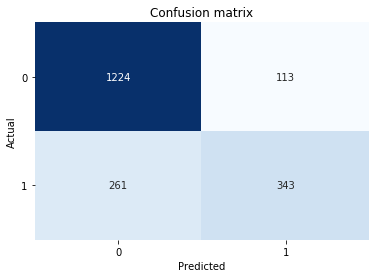

seperator
seperator
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1337
           1       0.78      0.62      0.69       604

    accuracy                           0.83      1941
   macro avg       0.81      0.77      0.79      1941
weighted avg       0.82      0.83      0.82      1941



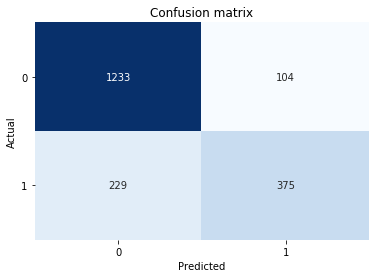

url
-url-
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1337
           1       0.75      0.56      0.65       604

    accuracy                           0.81      1941
   macro avg       0.79      0.74      0.76      1941
weighted avg       0.80      0.81      0.80      1941



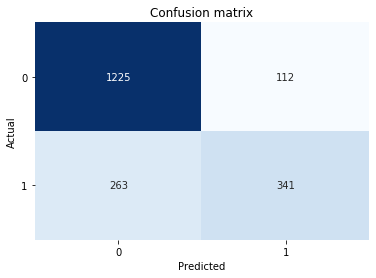

mention
-mention-
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1337
           1       0.75      0.56      0.65       604

    accuracy                           0.81      1941
   macro avg       0.79      0.74      0.76      1941
weighted avg       0.80      0.81      0.80      1941



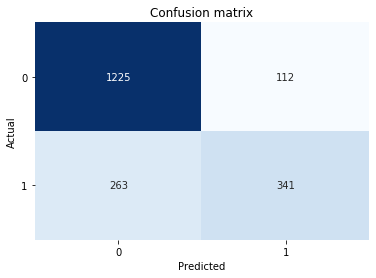

number
-number-
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1337
           1       0.75      0.57      0.65       604

    accuracy                           0.81      1941
   macro avg       0.79      0.74      0.76      1941
weighted avg       0.80      0.81      0.80      1941



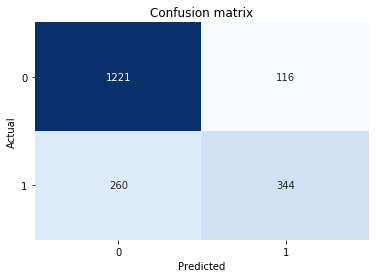

non_sinhala
-non_sinhala-
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1337
           1       0.75      0.56      0.65       604

    accuracy                           0.81      1941
   macro avg       0.79      0.74      0.76      1941
weighted avg       0.80      0.81      0.80      1941



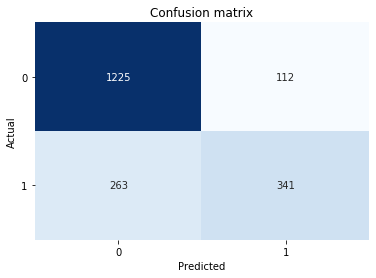

special_characters
-special charactrer-
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1337
           1       0.75      0.56      0.65       604

    accuracy                           0.81      1941
   macro avg       0.79      0.74      0.76      1941
weighted avg       0.80      0.81      0.80      1941



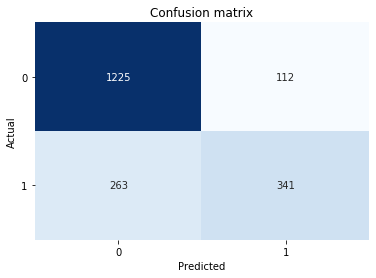

puntuation
-puntuation-
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1337
           1       0.76      0.64      0.69       604

    accuracy                           0.82      1941
   macro avg       0.80      0.77      0.79      1941
weighted avg       0.82      0.82      0.82      1941



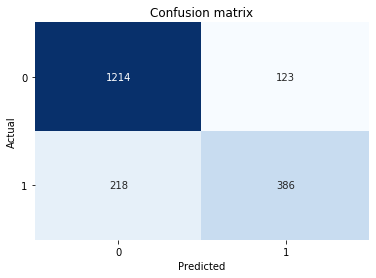

puntuation_special
-puntuation_special-
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1337
           1       0.76      0.64      0.70       604

    accuracy                           0.83      1941
   macro avg       0.80      0.78      0.79      1941
weighted avg       0.82      0.83      0.82      1941



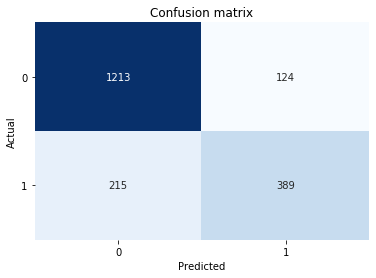

emoji_remove
-emoji remove-
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1337
           1       0.75      0.56      0.65       604

    accuracy                           0.81      1941
   macro avg       0.79      0.74      0.76      1941
weighted avg       0.80      0.81      0.80      1941



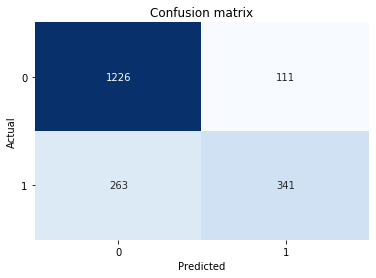

stop_word
-stop word-
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1337
           1       0.76      0.56      0.65       604

    accuracy                           0.81      1941
   macro avg       0.79      0.74      0.76      1941
weighted avg       0.80      0.81      0.80      1941



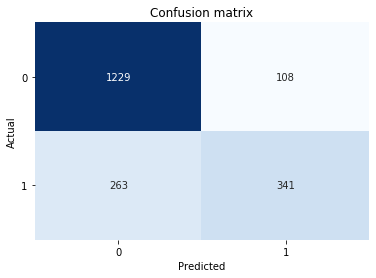

stem
-stem-
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1337
           1       0.77      0.59      0.67       604

    accuracy                           0.82      1941
   macro avg       0.80      0.75      0.77      1941
weighted avg       0.81      0.82      0.81      1941



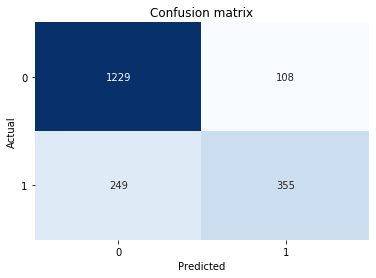

custom_stem
-custome stemmer-
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1337
           1       0.74      0.61      0.67       604

    accuracy                           0.81      1941
   macro avg       0.79      0.76      0.77      1941
weighted avg       0.81      0.81      0.81      1941



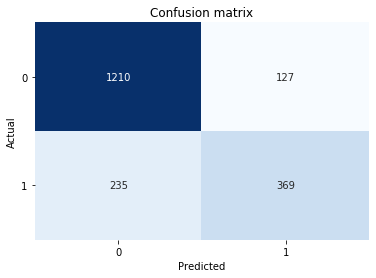

,Accuracy,F1-score,Recall,Precision,AUC
baseline,0.807316,0.647170,0.567881,0.752193,0.741682
seperator,0.828439,0.692521,0.620861,0.782881,0.771537
url,0.806801,0.645222,0.564570,0.752759,0.740400
mention,0.806801,0.645222,0.564570,0.752759,0.740400
number,0.806285,0.646617,0.569536,0.747826,0.741388
non_sinhala,0.806801,0.645222,0.564570,0.752759,0.740400
special_characters,0.806801,0.645222,0.564570,0.752759,0.740400
puntuation,0.824317,0.693621,0.639073,0.758350,0.773538
puntuation_special,0.825348,0.696509,0.644040,0.758285,0.775647
emoji_remove,0.807316,0.645833,0.564570,0.754425,0.740774


In [61]:
seperator = url= mention = number = non_sinhala = special_characters= puntuation =  puntuation_special = emoji_remove = stop_word =stem = custom_stem =False
preprocessing_steps = [seperator, url,mention , number , non_sinhala ,special_characters, puntuation , puntuation_special ,emoji_remove , stop_word, stem,custom_stem ]
final_result_A,df_cleaned_A = check_preprocessing(df_A)

### With combination of removing all noise+ punctuation_special and doing stemming

seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation_special-
-emoji remove-
-custome stemmer-
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1337
           1       0.75      0.66      0.71       604

    accuracy                           0.83      1941
   macro avg       0.80      0.78      0.79      1941
weighted avg       0.82      0.83      0.82      1941



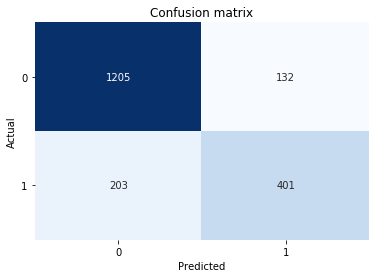

In [62]:
seperator = url= mention = number = non_sinhala = special_characters= puntuation =  puntuation_special = emoji_remove = stop_word =stem = custom_stem =False
preprocessing_steps = [True, True,True , number , True ,True, puntuation , True, True , stop_word, stem,True ]

df_clean_A_final = preprocessor(df_A,'comment',*preprocessing_steps)
X_train, X_test, Y_train, Y_test = train_test_split(df_clean_A_final['cleaned'], df_clean_A_final['label'], test_size=0.3, random_state=0, stratify=df_clean_A_final['label'].values)
X_train_f,X_test_f = bow_word(X_train,X_test)
Y_pred = lr(X_train_f,X_test_f,Y_train)
accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred)
final_result_A.loc["Final"] = [accuracy, f1_score, recall, precision, auc]

In [63]:
final_result_A

,Accuracy,F1-score,Recall,Precision,AUC
baseline,0.807316,0.647170,0.567881,0.752193,0.741682
seperator,0.828439,0.692521,0.620861,0.782881,0.771537
url,0.806801,0.645222,0.564570,0.752759,0.740400
mention,0.806801,0.645222,0.564570,0.752759,0.740400
number,0.806285,0.646617,0.569536,0.747826,0.741388
non_sinhala,0.806801,0.645222,0.564570,0.752759,0.740400
special_characters,0.806801,0.645222,0.564570,0.752759,0.740400
puntuation,0.824317,0.693621,0.639073,0.758350,0.773538
puntuation_special,0.825348,0.696509,0.644040,0.758285,0.775647
emoji_remove,0.807316,0.645833,0.564570,0.754425,0.740774


In [64]:
df_clean_A_final.head(n=15)

,comment,label,df,cleaned
0,මේ වේසිට නීතිය ක්‍රියාත්මක වෙන්නෙ කවදාද ?,1,A,මේ වේසිට නීතිය ක්‍රියාත් වෙ කවදාද ?
1,තූ ෙනදකින්,1,A,තූ ෙනද
2,අම්මා ලුසීඩා කියුවම මට හිතෙන්නම ෆලූඩා කියලා. හිකිස්. ඔව් ඔව් තරුණ වයසේ ගෑණු ළමයි විවිඪ රට වලින් ආශ්‍රය කලාට කමක් නෑ. ලෙඩක් කාරියේ හදා ගත්තම තේරෙයි අප්පගේ ආදර බර පුතාට​.,0,A,අම්මා ලුසීඩ කියුව මට හිතෙන්න ෆලූඩා කියලා හිකිස ඔව් ඔව් තරුණ වයසේ ගෑණු ළමයි විවිඪ රට වලින් ආශ්‍ර කලාට කමක් නෑ ලෙඩක් කාරි හදා ගත්තම තේරෙ අප්ප ආදර බර පුතාට
3,දින ඒකාබද්ධ විපක්ෂයේ මාධ්‍ය ලේකම් රේණුක පෙරේරා මහතාගේ නිවේදනයට අදාාලව අමිත් වීරසිංහ කල මාධ්‍ය සාකච්ඡාව..…,0,A,දින ඒකාබද්ධ විපක්ෂ මාධ්‍ ලේකම් රේණුක පෙරේර මහත නිවේදන අදාාල අමිත් වීරසිංහ කල මාධ්‍ සාකච්ඡා
4,පූදින්ෙන නැතුව ඉදිං,1,A,පූදින්ෙ නැතුව ඉදිං
5,ඇමති පඩිය ඇතිද කියල අහුවම මේකි කියන්නේ වාහන් දෙකයි එයාට තියෙන්නේ කියලා. එතකොට අප්පටයි,1,A,ඇමති පඩිය ඇතිද කියල අහුවම මේකි කිය වාහන් දෙකයි එයාට තියෙ කියලා එතකොට අප්පට
6,මා හෝ ඒකාබද්ධ විපක්ෂය මගින් හෝ දැනට පවතින කිසිම පක්ෂයකින් ඡන්දයකට ඉදිරිපත් වෙනවා කියා නැ.. ඒකාබද්ධ විපක්ෂය වැනි වි…,0,A,මා හෝ ඒකාබද්ධ විපක්ෂ මගින් හෝ දැනට පවතින කිසිම පක්ෂ ඡන්ද ඉදිරිප වෙනවා කියා නැ ඒකාබද්ධ විපක්ෂ වැනි වි
7,උඹ එක්ක එකඟවෙන්න පුලුවන් කථාවක් තමයි අද බොලා කියලා තියෙන්නෙ...මුන්ගෙ සනුහරේම උපන් ගෙයි මරිමෝඩ හැත්තක්...මූ නීති විභාගයෙන් ලංකාවෙන්ම වැඩිම ලකුණු අරගෙන වාර්තා පිහිටුවාලු සමත් උනේ ඒත් උන්ගෙ හිතවතුන්ගෙ සියලුම නඩු වලට නීතිඥයො හොයාගෙන එන්නෙ පිටින්. ලොකු උන් වගේම පොඩි උනුත් කම්බා හොරු...මේ වසල පවුලේ සුබ සිද්දියට කාබාසිනියා කරපු මුදල් ලංකාවෙ සාවර්ධනයට යොදාගත්තා නම් ලංකාව මීට වඩා ගොඩාක් වෙනස් තැනක අද තියෙන්නෙ..තූ නෙදකින්,1,A,උඹ එක්ක එකඟවෙ පුලු කථා තමයි අද බොලා කියලා තියෙ මුන් සනුහරේ උපන් ගෙයි මරිමෝඩ හැත්ත මූ නීති විභාග ලංකාවෙන් වැඩිම ලකුණු අරගෙන වාර්ත පිහිටුවාල සමත් උනේ ඒත් උන්ගෙ හිතවතුන් සියල නඩු වලට නීතිඥය හොයාගෙ එන්නෙ පිට ලොකු උන් වගේම පොඩි උනුත් කම්බා හොරු මේ වසල පවුලේ සුබ සිද්දි කාබාසිනි කරපු මුදල් ලංකා සාවර්ධන යොදාගත්ත නම් ලංකාව මීට වඩා ගොඩා වෙනස් තැනක අද තියෙ තූ නෙද
8,කොළඹ යුගයේදී කියලා වෙන්න ඇති මගේ හිතේ කියන්න ඇත්තේ.... හිකිස්... ඒ පවුල හරි දැන උගත් පවුලක්නේ මචෝ,0,A,කොළඹ යුග කියලා වෙන්න ඇති මගේ හිතේ කිය ඇත්තේ හිකිස ඒ පවුල හරි දැන උගත් පවුලක්න මචෝ
9,කිමද මේ තරම් කොහේදෝ ඇති විදපු ගලක් හා උරන මා මිතුරු පරය?,0,A,කිමද මේ තරම් කොහේද ඇති විදපු ගලක් හා උරන මා මිතුර පරය?


## Kaggle dataset preproceeing evaluation

In [65]:
df_B.head()

,comment,label,df
0,`හුදෙකලා´ එකේ `ද´ ඇහෙනවද කාටහරි,0,B
1,18ක පෙනුමක් තියෙන්නේ,0,B
2,2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට,0,B
3,25 කැල්ල..හම්මෝ..,0,B
4,25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ,1,B


### Mutual exclusive evaluation for dataset B

baseline
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       867
           1       0.88      0.79      0.83      1037

    accuracy                           0.83      1904
   macro avg       0.83      0.83      0.83      1904
weighted avg       0.83      0.83      0.83      1904



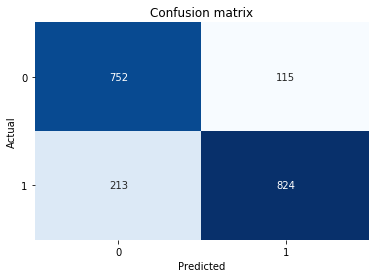

seperator
seperator
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       867
           1       0.88      0.80      0.84      1037

    accuracy                           0.84      1904
   macro avg       0.84      0.84      0.83      1904
weighted avg       0.84      0.84      0.84      1904



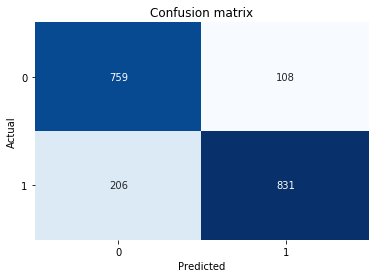

url
-url-
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       867
           1       0.88      0.80      0.84      1037

    accuracy                           0.83      1904
   macro avg       0.83      0.83      0.83      1904
weighted avg       0.83      0.83      0.83      1904



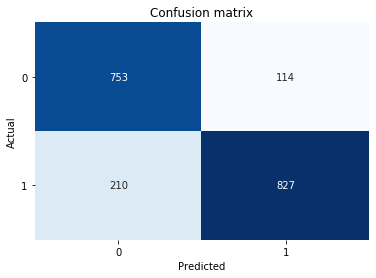

mention
-mention-
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       867
           1       0.88      0.80      0.84      1037

    accuracy                           0.83      1904
   macro avg       0.83      0.83      0.83      1904
weighted avg       0.83      0.83      0.83      1904



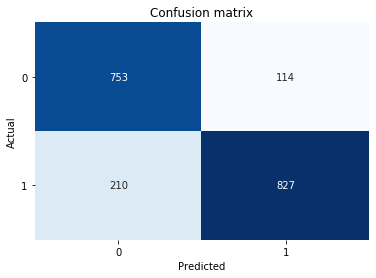

number
-number-
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       867
           1       0.88      0.79      0.83      1037

    accuracy                           0.83      1904
   macro avg       0.83      0.83      0.83      1904
weighted avg       0.83      0.83      0.83      1904



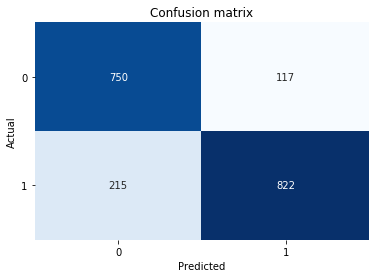

non_sinhala
-non_sinhala-
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       867
           1       0.88      0.80      0.83      1037

    accuracy                           0.83      1904
   macro avg       0.83      0.83      0.83      1904
weighted avg       0.83      0.83      0.83      1904



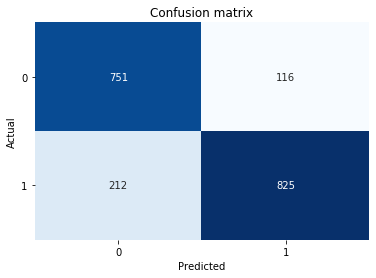

special_characters
-special charactrer-
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       867
           1       0.88      0.80      0.84      1037

    accuracy                           0.83      1904
   macro avg       0.83      0.83      0.83      1904
weighted avg       0.83      0.83      0.83      1904



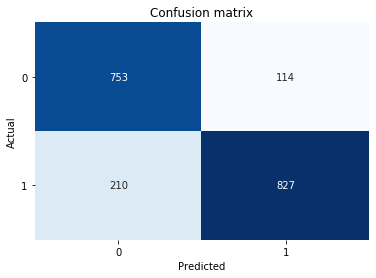

puntuation
-puntuation-
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       867
           1       0.88      0.81      0.85      1037

    accuracy                           0.84      1904
   macro avg       0.84      0.84      0.84      1904
weighted avg       0.84      0.84      0.84      1904



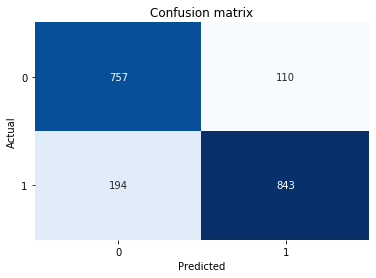

puntuation_special
-puntuation_special-
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       867
           1       0.89      0.81      0.85      1037

    accuracy                           0.84      1904
   macro avg       0.84      0.84      0.84      1904
weighted avg       0.85      0.84      0.84      1904



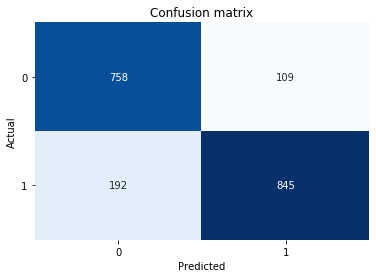

emoji_remove
-emoji remove-
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       867
           1       0.88      0.80      0.84      1037

    accuracy                           0.83      1904
   macro avg       0.83      0.83      0.83      1904
weighted avg       0.83      0.83      0.83      1904



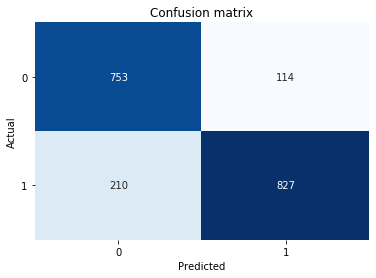

stop_word
-stop word-
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       867
           1       0.89      0.79      0.83      1037

    accuracy                           0.83      1904
   macro avg       0.83      0.83      0.83      1904
weighted avg       0.84      0.83      0.83      1904



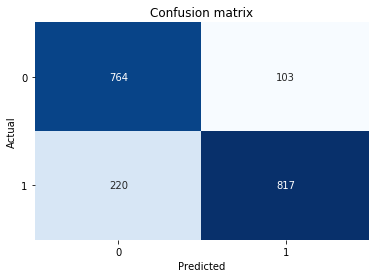

stem
-stem-
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       867
           1       0.87      0.80      0.83      1037

    accuracy                           0.83      1904
   macro avg       0.83      0.83      0.83      1904
weighted avg       0.83      0.83      0.83      1904



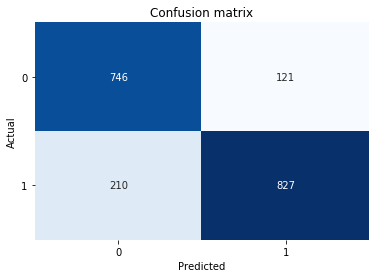

custom_stem
-custome stemmer-
              precision    recall  f1-score   support

           0       0.80      0.88      0.83       867
           1       0.89      0.81      0.85      1037

    accuracy                           0.84      1904
   macro avg       0.84      0.84      0.84      1904
weighted avg       0.85      0.84      0.84      1904



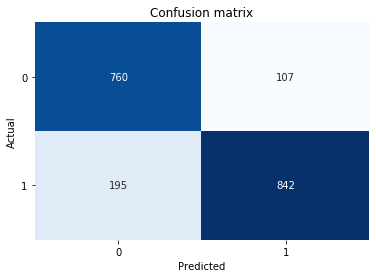

,Accuracy,F1-score,Recall,Precision,AUC
baseline,0.827731,0.834008,0.794600,0.877529,0.830979
seperator,0.835084,0.841093,0.801350,0.884984,0.838391
url,0.829832,0.836198,0.797493,0.878852,0.833002
mention,0.829832,0.836198,0.797493,0.878852,0.833002
number,0.825630,0.831984,0.792671,0.875399,0.828862
non_sinhala,0.827731,0.834176,0.795564,0.876727,0.830885
special_characters,0.829832,0.836198,0.797493,0.878852,0.833002
puntuation,0.840336,0.847236,0.812922,0.884575,0.843024
puntuation_special,0.841912,0.848820,0.814851,0.885744,0.844565
emoji_remove,0.829832,0.836198,0.797493,0.878852,0.833002


In [66]:
seperator = url= mention = number = non_sinhala = special_characters= puntuation =  puntuation_special = emoji_remove = stop_word =stem = custom_stem =False
preprocessing_steps = [seperator, url,mention , number , non_sinhala ,special_characters, puntuation , puntuation_special ,emoji_remove , stop_word, stem,custom_stem ]
final_result_B,df_cleaned_B = check_preprocessing(df_B)

In [50]:
df_cleaned_B.head()

,comment,label,df,cleaned
0,`හුදෙකලා´ එකේ `ද´ ඇහෙනවද කාටහරි,0,B,`හුදෙකලා´ එ `ද´ ඇහෙන කාටහරි
1,18ක පෙනුමක් තියෙන්නේ,0,B,18ක පෙන තියෙ
2,2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට,0,B,2020 එ කිව්න මෙහෙ එ කිය හිත නෑ පට්
3,25 කැල්ල..හම්මෝ..,0,B,25 කැල්ල..හම්මෝ..
4,25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ,1,B,25 කෙල් අයියල කාල කොහෙ ඉ


### Best performed combination removing number, emoji, puctuation

seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation_special-
-emoji remove-
-custome stemmer-
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       867
           1       0.89      0.82      0.86      1037

    accuracy                           0.85      1904
   macro avg       0.85      0.85      0.85      1904
weighted avg       0.85      0.85      0.85      1904



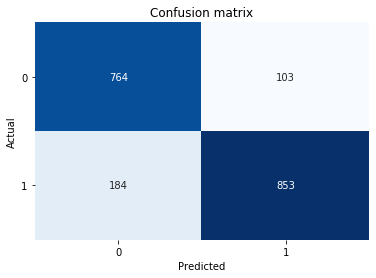

In [73]:
seperator = url= mention = number = non_sinhala = special_characters= puntuation =  puntuation_special = emoji_remove = stop_word =stem = custom_stem =False
preprocessing_steps = [True, True,True , number , True ,True, puntuation , True ,True, stop_word, stem,True ]
df_clean_B_final = preprocessor(df_B,'comment',*preprocessing_steps)
X_train, X_test, Y_train, Y_test = train_test_split(df_clean_B_final['cleaned'], df_clean_B_final['label'], test_size=0.3, random_state=0, stratify=df_clean_B_final['label'].values)
X_train_f,X_test_f = bow_word(X_train,X_test)
Y_pred = lr(X_train_f,X_test_f,Y_train)
accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred)
final_result_B.loc["Final"] = [accuracy, f1_score, recall, precision, auc]

In [74]:
final_result_B

,Accuracy,F1-score,Recall,Precision,AUC
baseline,0.827731,0.834008,0.794600,0.877529,0.830979
seperator,0.835084,0.841093,0.801350,0.884984,0.838391
url,0.829832,0.836198,0.797493,0.878852,0.833002
mention,0.829832,0.836198,0.797493,0.878852,0.833002
number,0.825630,0.831984,0.792671,0.875399,0.828862
non_sinhala,0.827731,0.834176,0.795564,0.876727,0.830885
special_characters,0.829832,0.836198,0.797493,0.878852,0.833002
puntuation,0.840336,0.847236,0.812922,0.884575,0.843024
puntuation_special,0.841912,0.848820,0.814851,0.885744,0.844565
emoji_remove,0.829832,0.836198,0.797493,0.878852,0.833002


In [76]:
df_clean_B_final.tail()

,comment,label,df,cleaned
6340,ෆට්ට ඒත් ඉතින් ඔහේ ඔක්සිජන් ඔනී නැතී සෙට් එකක් ඉන්නවා නේ,0,B,ෆට්ට ඒත් ඉතින් ඔහේ ඔක්සිජ ඔනී නැතී සෙට් එකක් ඉන් නේ
6341,ෆයිනලි,0,B,ෆයිනලි
6342,ෆුකෙන් හිනා මේවට...,1,B,ෆු හිනා මේවට
6343,"ෆෝන් එක චාර්ජ් කරගනින්,29%. පට්ට.....",0,B,ෆෝන් එක චාර්ජ කරගන 29 පට්ට
6344,"ෆ්ලෑශ් ටෙලිඩ්‍රාමා එක ඇත්ත තියරියක් වෙන්නත් ඇති.එකම මානයක පුදිගලයින් දෙන්නෙක් විදියට පෙනී සිටීම,නමුත් මෙතන හෝ යන අයගෙන් එක් අයෙකුට එකම මානයක අතීතයට හෝ අනාගතයට යෑමේ හැකියාවත් තියනව..",0,B,ෆ්ලෑශ ටෙලිඩ්‍රාම එක ඇත්ත තියරි වෙන්න ඇති එකම මානයක පුදිගලය දෙන්න විදි පෙනී සිටීම නමුත් මෙතන හෝ යන අ එක් අ එකම මානයක අතීත හෝ අනාගත යෑමේ හැකියා තියනව


## TODO and optional- Simple Dense deep neural network

In [ ]:
def train_model(model,train_seq,test_seq,Y_train,Y_test):
  
  #define callbacks
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
  #callbacks_list = [early_stopping]

  #model training
  hist = model.fit(train_seq, Y_train, batch_size=batch_size, epochs=num_epochs, callbacks=[early_stopping],validation_split=0.1, shuffle=True, verbose=2)
  train_loss, train_acc = model.evaluate(train_seq, Y_train,batch_size=batch_size, verbose=1)
  print("train loss - ",train_loss," train acc- ",train_acc)
  test_loss, test_acc = model.evaluate(test_seq,Y_test,batch_size=batch_size, verbose=1)
  print("test loss - ",test_loss," test acc- ",test_acc)

  # plot loss during training
  from matplotlib import pyplot
  print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
  pyplot.subplot(211)
  pyplot.title('Loss')
  pyplot.xlabel('Epochs')
  pyplot.ylabel("Cross Entropy Loss")
  pyplot.plot(hist.history['loss'],lw=2.0, color='b', label='train')
  pyplot.plot(hist.history['val_loss'],lw=2.0, color='r', label='validation')
  pyplot.legend(loc='upper right')
  # plot accuracy during training
  pyplot.subplot(212)
  pyplot.title('Accuracy')
  pyplot.xlabel('Epochs')
  pyplot.ylabel('Accuracy')
  pyplot.plot(hist.history['accuracy'],lw=2.0, color='b', label='train')
  pyplot.plot(hist.history['val_accuracy'],lw=2.0, color='r', label='validation')
  pyplot.legend(loc='upper right')
  pyplot.show()
  #(model.predict(x) > 0.5).astype("int32")
  #np.where(y_pred > threshold, 1,0)
  Y_pred =(model.predict(test_seq) > 0.5).astype("int32")# model.predict_class(test_seq)
  Y_pred = np.squeeze(Y_pred)
  print(metrics.classification_report(Y_test,Y_pred))
  #Y_pred = np.squeeze(Y_pred)
  utills.confusion_Matrix(Y_test,Y_pred)
  utills.PlotRocAuc(Y_test,Y_pred,'blue',"CNN")
  return model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 30

def nn(X_train,y_train):
    simple_nn = Sequential()
    simple_nn.add(Dense(150, activation='relu', input_shape=(119,)))
    simple_nn.add(Dropout(0.2))
    simple_nn.add(Dense(100, activation='relu'))
    simple_nn.add(Dropout(0.2))
    simple_nn.add(Dense(100, activation='relu'))
    simple_nn.add(Dropout(0.2))
    simple_nn.add(Dense(1, activation='sigmoid'))

    simple_nn.summary()

    simple_nn.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

    # checkpoint = ModelCheckpoint('./saved_models', monitor = 'val_accuracy', verbose = 1, save_best_only=True)
    # history = simple_nn.fit(train_features.todense(), y_train,
    #                     batch_size=batch_size,
    #                     epochs=epochs,
    #                     verbose=1,
    #                     callbacks = [checkpoint],
    #                     validation_data=(test_features.todense(), y_test))
    return simple_nn

In [ ]:
model_p1 =train_model(simple_nn, train_seq, test_seq, Y_train, Y_test)

In [ ]:
from tensorflow.keras.models import load_model

simple_nn = load_model('./saved_models')
y_pred_prob = simple_nn.predict(test_features.todense())
print_model_metrics(y_test, y_pred_prob)

### Without any preprocessing

In [ ]:
nn()

### With best preprocessing combination

nn()

## Dataset A and B 

### Mutual exclusive preproxxessing

baseline
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2204
           1       0.81      0.69      0.75      1640

    accuracy                           0.80      3844
   macro avg       0.80      0.79      0.79      3844
weighted avg       0.80      0.80      0.80      3844



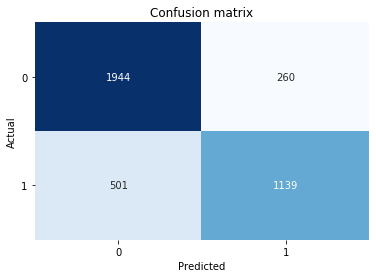

seperator
seperator
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2204
           1       0.82      0.71      0.76      1640

    accuracy                           0.81      3844
   macro avg       0.81      0.80      0.80      3844
weighted avg       0.81      0.81      0.81      3844



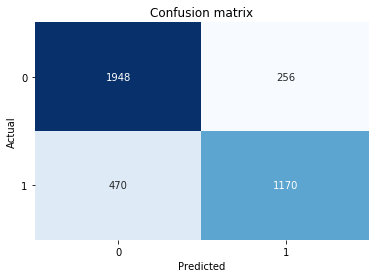

url
-url-
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2204
           1       0.82      0.69      0.75      1640

    accuracy                           0.80      3844
   macro avg       0.81      0.79      0.79      3844
weighted avg       0.80      0.80      0.80      3844



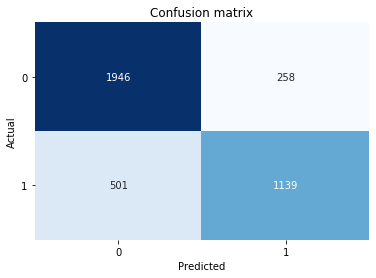

mention
-mention-
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2204
           1       0.82      0.70      0.75      1640

    accuracy                           0.80      3844
   macro avg       0.81      0.79      0.79      3844
weighted avg       0.80      0.80      0.80      3844



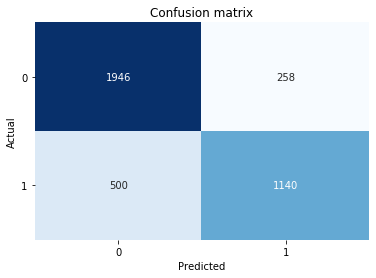

number
-number-
              precision    recall  f1-score   support

           0       0.79      0.88      0.84      2204
           1       0.81      0.69      0.75      1640

    accuracy                           0.80      3844
   macro avg       0.80      0.79      0.79      3844
weighted avg       0.80      0.80      0.80      3844



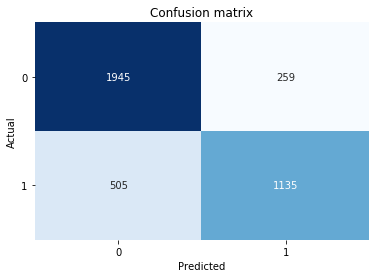

non_sinhala
-non_sinhala-
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2204
           1       0.81      0.70      0.75      1640

    accuracy                           0.80      3844
   macro avg       0.81      0.79      0.79      3844
weighted avg       0.80      0.80      0.80      3844



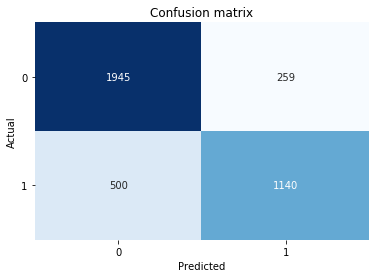

special_characters
-special charactrer-
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2204
           1       0.82      0.70      0.75      1640

    accuracy                           0.80      3844
   macro avg       0.81      0.79      0.79      3844
weighted avg       0.80      0.80      0.80      3844



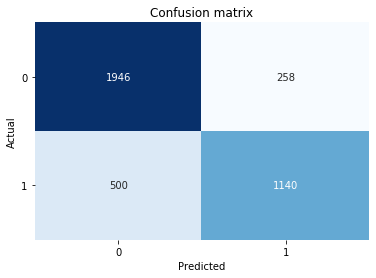

puntuation
-puntuation-
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      2204
           1       0.83      0.73      0.77      1640

    accuracy                           0.82      3844
   macro avg       0.82      0.81      0.81      3844
weighted avg       0.82      0.82      0.82      3844



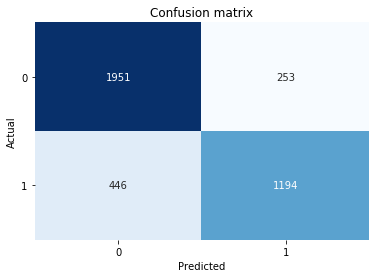

puntuation_special
-puntuation_special-
              precision    recall  f1-score   support

           0       0.81      0.88      0.85      2204
           1       0.82      0.72      0.77      1640

    accuracy                           0.82      3844
   macro avg       0.82      0.80      0.81      3844
weighted avg       0.82      0.82      0.81      3844



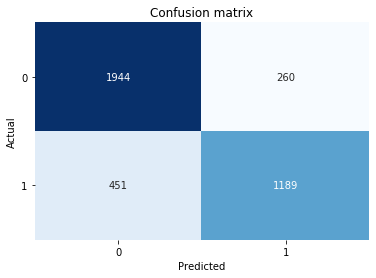

emoji_remove
-emoji remove-
              precision    recall  f1-score   support

           0       0.79      0.88      0.84      2204
           1       0.81      0.69      0.75      1640

    accuracy                           0.80      3844
   macro avg       0.80      0.79      0.79      3844
weighted avg       0.80      0.80      0.80      3844



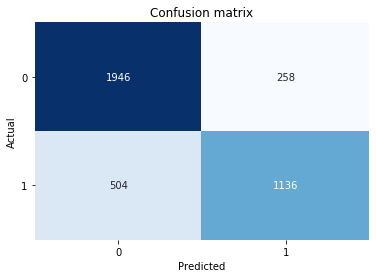

stop_word
-stop word-
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2204
           1       0.82      0.70      0.76      1640

    accuracy                           0.81      3844
   macro avg       0.81      0.79      0.80      3844
weighted avg       0.81      0.81      0.80      3844



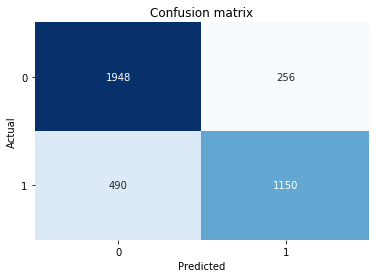

stem
-stem-
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      2204
           1       0.80      0.69      0.74      1640

    accuracy                           0.79      3844
   macro avg       0.79      0.78      0.78      3844
weighted avg       0.79      0.79      0.79      3844



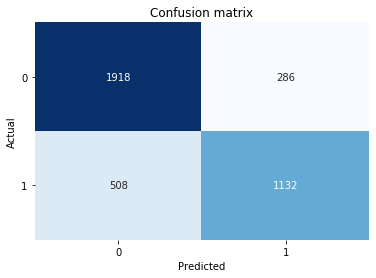

custom_stem
-custome stemmer-
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2204
           1       0.82      0.71      0.76      1640

    accuracy                           0.81      3844
   macro avg       0.81      0.80      0.80      3844
weighted avg       0.81      0.81      0.81      3844



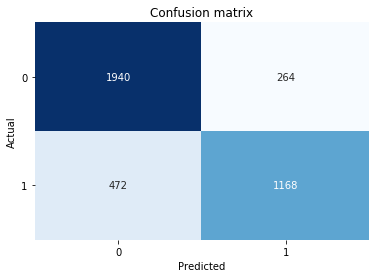

,Accuracy,F1-score,Recall,Precision,AUC
baseline,0.802029,0.749589,0.694512,0.814153,0.788272
seperator,0.811134,0.763209,0.713415,0.820477,0.798631
url,0.802549,0.750082,0.694512,0.815319,0.788726
mention,0.802810,0.750494,0.695122,0.815451,0.789031
number,0.801249,0.748187,0.692073,0.814204,0.787280
non_sinhala,0.802549,0.750247,0.695122,0.814868,0.788804
special_characters,0.802810,0.750494,0.695122,0.815451,0.789031
puntuation,0.818158,0.773567,0.728049,0.825155,0.806629
puntuation_special,0.815036,0.769828,0.725000,0.820566,0.803516
emoji_remove,0.801769,0.748846,0.692683,0.814921,0.787812


In [77]:
seperator = url= mention = number = non_sinhala = special_characters= puntuation =  puntuation_special = emoji_remove = stop_word =stem = custom_stem =False
preprocessing_steps = [seperator, url,mention , number , non_sinhala ,special_characters, puntuation , puntuation_special ,emoji_remove , stop_word, stem,custom_stem ]
final_result_A_B, df_cleaned_A_B= check_preprocessing(df_A_B)

### Best combinations

seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation_special-
-emoji remove-
-custome stemmer-
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2204
           1       0.83      0.74      0.78      1640

    accuracy                           0.83      3844
   macro avg       0.83      0.82      0.82      3844
weighted avg       0.83      0.83      0.82      3844



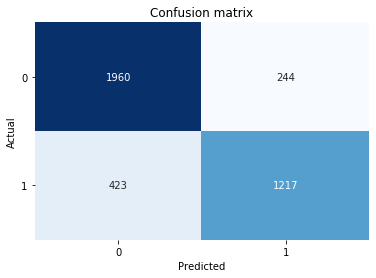

In [78]:
seperator = url= mention = number = non_sinhala = special_characters= puntuation =  puntuation_special = emoji_remove = stop_word =stem = custom_stem =False
preprocessing_steps = [True, True,True , number , True ,True, puntuation , True ,True, stop_word, stem,True ]
df_clean_A_B_final = preprocessor(df_A_B,'comment',*preprocessing_steps)
X_train, X_test, Y_train, Y_test = train_test_split(df_clean_A_B_final['cleaned'], df_clean_A_B_final['label'], test_size=0.3, random_state=0, stratify=df_clean_A_B_final['label'].values)
X_train_f,X_test_f = bow_word(X_train,X_test)
Y_pred = lr(X_train_f,X_test_f,Y_train)
accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred)
final_result_A_B.loc["Final"] = [accuracy, f1_score, recall, precision, auc]

In [80]:
final_result_A_B

,Accuracy,F1-score,Recall,Precision,AUC
baseline,0.802029,0.749589,0.694512,0.814153,0.788272
seperator,0.811134,0.763209,0.713415,0.820477,0.798631
url,0.802549,0.750082,0.694512,0.815319,0.788726
mention,0.802810,0.750494,0.695122,0.815451,0.789031
number,0.801249,0.748187,0.692073,0.814204,0.787280
non_sinhala,0.802549,0.750247,0.695122,0.814868,0.788804
special_characters,0.802810,0.750494,0.695122,0.815451,0.789031
puntuation,0.818158,0.773567,0.728049,0.825155,0.806629
puntuation_special,0.815036,0.769828,0.725000,0.820566,0.803516
emoji_remove,0.801769,0.748846,0.692683,0.814921,0.787812


In [82]:
df_clean_A_B_final.head()

,comment,label,df,cleaned
0,මේ වේසිට නීතිය ක්‍රියාත්මක වෙන්නෙ කවදාද ?,1,A,මේ වේසිට නීතිය ක්‍රියාත් වෙ කවදාද ?
1,තූ ෙනදකින්,1,A,තූ ෙනද
2,අම්මා ලුසීඩා කියුවම මට හිතෙන්නම ෆලූඩා කියලා. හිකිස්. ඔව් ඔව් තරුණ වයසේ ගෑණු ළමයි විවිඪ රට වලින් ආශ්‍රය කලාට කමක් නෑ. ලෙඩක් කාරියේ හදා ගත්තම තේරෙයි අප්පගේ ආදර බර පුතාට​.,0,A,අම්මා ලුසීඩ කියුව මට හිතෙන්න ෆලූඩා කියලා හිකිස ඔව් ඔව් තරුණ වයසේ ගෑණු ළමයි විවිඪ රට වලින් ආශ්‍ර කලාට කමක් නෑ ලෙඩක් කාරි හදා ගත්තම තේරෙ අප්ප ආදර බර පුතාට
3,දින ඒකාබද්ධ විපක්ෂයේ මාධ්‍ය ලේකම් රේණුක පෙරේරා මහතාගේ නිවේදනයට අදාාලව අමිත් වීරසිංහ කල මාධ්‍ය සාකච්ඡාව..…,0,A,දින ඒකාබද්ධ විපක්ෂ මාධ්‍ ලේකම් රේණුක පෙරේර මහත නිවේදන අදාාල අමිත් වීරසිංහ කල මාධ්‍ සාකච්ඡා
4,පූදින්ෙන නැතුව ඉදිං,1,A,පූදින්ෙ නැතුව ඉදිං


## Save best combination of preprocessed datasets df_A,df_B,df_A_B,df_all

In [84]:
# dataset name list
import os
folder_path = 'G:\\Github\\Sinhala-Hate-Speech-Detection\\Datasets\\processed\\preprocessing\\'
df_dict = {'df_A': df_clean_A_final,'df_B': df_clean_B_final,'df_A_B' :df_clean_A_B_final}
for name,df in df_dict.items():
    print(os.path.join(folder_path,f'{name}.csv'))
    df.to_csv(os.path.join(folder_path,f'{name}.csv'), index=False)

G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\preprocessing\df_A.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\preprocessing\df_B.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\preprocessing\df_A_B.csv
